In [1]:
import openml
from benchmark_utils import *

In [8]:
benchmark_suite = openml.study.get_study('OpenML-CC18','tasks') # obtain the benchmark suite
M = len(benchmark_suite.tasks)

# The number of times to run each algorithm
n_iterations = 10

# RerF types to benchmark, the duplicate is to allow for RerFs with different
# parameters
rerfs = ['rfBase', 
         'binnedBase',
    ]

# RerF parameters
rerf_kwargs = [
    {
    'trees' : 1000,
    'numCores' : 8,
    'minParent' : 25,
    },
#     {
#     'trees' : 20,
#     'mtryMult': 2, # Comment this line out if RerF version does not support mtryMult
#     'numCores' : 8,
#     }
    ]

# Keyword of the parameter we are changing/iterating over
rerf_param_keyword='trees'

# Sklearn forest types to benchmark
sklearns = ['RandomForest', 'ExtraTrees']

# If all forests share the same parameters only need to pass single dictionary 
sklearn_kwargs = [{
    'n_estimators' : 1000,
    'n_jobs' : 8,
    'min_samples_split' : 25
}]

# Sklearn keyword of the parameter we are changing/iterating over
sklearn_param_keyword='n_estimators'

# The prameter values to consider 
# param_values = np.arange(20, 101, step=20)
param_values = np.arange(1000, 1001, step = 20)

# A list of all forest types (duplicates included)
all_forests = np.concatenate((rerfs, sklearns))
F = len(all_forests)

predictions = [[[] for j in range(M)] for i in range(F)]
train_times = [[[] for j in range(M)] for i in range(F)]
predict_times = [[[] for j in range(M)] for i in range(F)]
test_accuracies = [[[] for j in range(M)] for i in range(F)]

error_idx = []

In [ ]:
for i in tqdm(range(len(benchmark_suite.tasks))):
    try:
        averages, std_errs, preds = OpenML_benchmark(oml_task_id=benchmark_suite.tasks[i], # Select an OpenML task via its task id
            n_iterations=n_iterations,
            train_test_splits = None, # None forces default OpenML train/test splits
            rerfs=rerfs, # A list of random forest types
            rerfs_kwargs=rerf_kwargs, # A list of dictionaries of RerF parameters
            rerf_param_keyword=rerf_param_keyword, # The keyword of parameter we are changing (i.e. 'trees')
            sklearns=sklearns, # A list of sklearn forest types
            sklearns_kwargs=sklearn_kwargs, # A list of dictionaries of Sklearn parameters
            sklearn_param_keyword=sklearn_param_keyword, # The keyword of parameter we are changing (i.e. 'n_estimators')
            param_values = param_values, # A list of values for the parameter we are changing
            verbose=False, # Progress bar!
            return_predictions=True,
            acorn=None
        )
        for j in range(F):
            predictions[i][j] = preds[j]
            test_accuracies[i][j] = averages[j][0][0]
            train_times[i][j] = averages[j][2][0]
            predict_times[i][j] = averages[j][3][0]

    except:
        error_idx.append(benchmark_suite.tasks[i])

In [ ]:
import _pickle as pickle

pickle.dump(predictions, open('openMLbenchmark_predictions.pkl', 'wb'))
pickle.dump(train_times, open('openMLbenchmark_train_times.pkl', 'wb'))
pickle.dump(test_accuracies, open('openMLbenchmark_test_accuracies.pkl', 'wb'))
pickle.dump(predict_times, open('openMLbenchmark_predict_times.pkl', 'wb'))
pickle.dump(error_idx, open('openMLbenchmark_error_idx.pkl', 'wb'))

In [5]:
# Choose an OpenML task id 
task_id=3

# The number of times to run each algorithm
n_iterations = 10

# RerF types to benchmark, the duplicate is to allow for RerFs with different
# parameters
rerfs = ['rfBase', 
         'binnedBase',
    ]

# RerF parameters
rerf_kwargs = [
    {
    'trees' : 1000,
    'numCores' : 8,
    },
    {
    'trees' : 1000,
    'numCores' : 8,
    },
#     {
#     'trees' : 20,
#     'mtryMult': 2, # Comment this line out if RerF version does not support mtryMult
#     'numCores' : 8,
#     }
    ]

# Keyword of the parameter we are changing/iterating over
rerf_param_keyword='trees'

# Sklearn forest types to benchmark
sklearns = ['RandomForest', 'ExtraTrees']

# If all forests share the same parameters only need to pass single dictionary 
sklearn_kwargs = [{
    'n_estimators' : 1000,
    'n_jobs' : 8,
}]

# Sklearn keyword of the parameter we are changing/iterating over
sklearn_param_keyword='n_estimators'

# The prameter values to consider 
# param_values = np.arange(20, 101, step=20)
param_values = np.arange(1000, 1001, step = 20)

# A list of all forest types (duplicates included)
all_forests = np.concatenate((rerfs, sklearns))

In [6]:
np.random.seed(1)
averages, std_errs = OpenML_benchmark(oml_task_id=task_id, # Select an OpenML task via its task id
              n_iterations=n_iterations,
              train_test_splits = None, # None forces default OpenML train/test splits
              rerfs=rerfs, # A list of random forest types
              rerfs_kwargs=rerf_kwargs, # A list of dictionaries of RerF parameters
              rerf_param_keyword=rerf_param_keyword, # The keyword of parameter we are changing (i.e. 'trees')
              sklearns=sklearns, # A list of sklearn forest types
              sklearns_kwargs=sklearn_kwargs, # A list of dictionaries of Sklearn parameters
              sklearn_param_keyword=sklearn_param_keyword, # The keyword of parameter we are changing (i.e. 'n_estimators')
              param_values = param_values, # A list of values for the parameter we are changing
              verbose=True, # Progress bar!
              acorn=None
            )

In [12]:
binnedRF = np.zeros(len())

0.9899999999999999

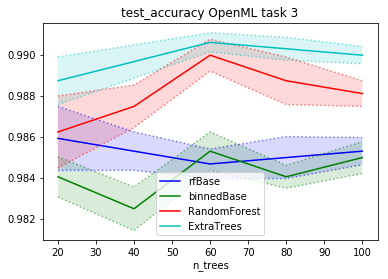

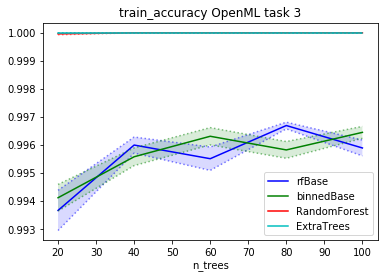

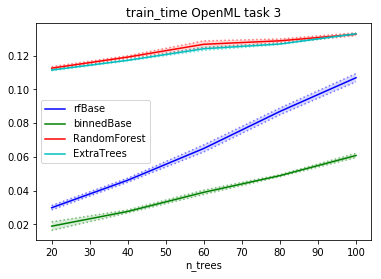

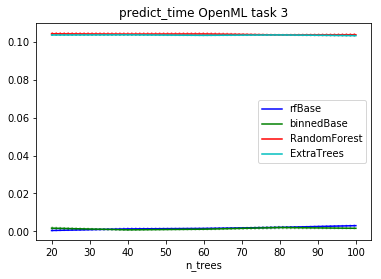

In [12]:
# Plots the results
# If save == True then saves the images to filename_title.png for each plot
results = OpenML_benchmark_plot([averages, std_errs],
                            param_values=param_values,
                            all_forests=all_forests, 
                            titles=['test_accuracy', 'train_accuracy', 'train_time', 'predict_time'],
                            task_id=3, 
                            param='n_trees', 
                            save=False,
                            filename='oml_task_3_no_preprocessing'
                    )